In [1585]:
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from statsmodels.graphics.api import interaction_plot, abline_plot
from statsmodels.stats.anova import anova_lm
import numpy as np
import pandas as pd
import ast
import statsmodels.api as sm

In [1586]:
#load data from dataframe
num_ranks=np.array([2,4,6,8,10,12,14,16,18,20,22,24])
num_halos=np.arange(2,16)

df2_plot = pd.read_csv ('big_df7.csv')
for i in num_halos:
    for j in num_ranks:
        df2_plot.at[i-2,str(j)]=ast.literal_eval(df2_plot.at[i-2,str(j)])

#only halo_update
z_tot=[]    
for i in num_ranks: 
    y=[]
    for j in num_halos:
        z_tot.append(df2_plot.loc[j-2][str(i)][0][1])
    #z_tot.append(y)
    #plt.plot(num_ranks, y)

In [1587]:
#only lap
z_lap=[]    
for i in num_ranks: 
    y=[]
    for j in num_halos:
        z_lap.append(df2_plot.loc[j-2][str(i)][0][2])
    #z_tot.append(y)
    #plt.plot(num_ranks, y)


In [1588]:
#total runtime
z_runtime=[]    
for i in num_ranks: 
    y=[]
    for j in num_halos:
        z_runtime.append(df2_plot.loc[j-2][str(i)][0][0])
    #z_tot.append(y)
#plt.plot(num_ranks, y)

In [1589]:
def runtime(X):
    num_iter=500
    nx=64
    ny=64
    nz=32
    nx=nx/np.sqrt(p)
    ny=ny/np.sqrt(p)
    T_comm=df_rank_halo_model
    beta_within_ranks=[1/68.3,1/77.5,1/155,1/155]
    cachesize=[32e3,256e3,30e6]
    lat_cache=np.array([4,15,51,151])/3e9
    for i in range(len(cachesize)):
        if 4*nx*ny*nz/p<cachesize[i]:
            T_per_rank=lat_cache[i]*nx*ny*nz/p #+ beta_within_ranks[i]*nx*ny*nz/p
        
        elif i==2:
            T_per_rank=lat_cache[3]*nx*ny*nz/p #+ beta_within_ranks[i]*nx*ny*nz/p
    T=T_comm+T_per_rank*num_iter
    
    return T_comm,T_per_rank, T


#alpha is overhead at sender/receiver + latency (2o + l)
def runtime_halo_update(X, alpha, beta_between_ranks):
    num_ranks,num_halo=X
    num_iter=500
    nx=64
    ny=64
    nz=32
    nx=nx/np.sqrt(num_ranks)
    ny=ny/np.sqrt(num_ranks)
    #alpha=1/500
    #beta_between_ranks=1/100
    #beta_within_ranks=[1/68.3,1/77.5,1/155,1/155]
    #cachesize=[32e3,256e3,30e6]
    #lat_cache=np.array([4,15,51,151])/3e9
    T_comm=[]
    for p,h in zip(range(len(num_ranks)),range(len(num_halo))):
        T_comm_p=num_iter*(4*alpha + 4*(2*nx[p]*num_halo[h]+2*(ny[p]+2*num_halo[h])*num_halo[h])*nz*beta_between_ranks)
        T_comm.append(T_comm_p.tolist())
    #T_comm=[item for sublist in T_comm for item in sublist]
    return T_comm

In [1590]:
#Create datframe for linear regression
df_comm_theory = pd.DataFrame(columns = ['X1','X2','X3','X4','Y'])
num_iter=10
nx=512
ny=512
nz=32
nx=nx/np.sqrt(num_ranks)
ny=ny/np.sqrt(num_ranks)
counter=0
for p in range(len(num_ranks)):
    for h in range(len(num_halos)):
        if num_ranks[p]<=12:
            a=0
            b=1
        else:
            a=1
            b=0
        df_comm_theory.at[counter,'X1']=num_iter* 4*(2*nx[p]*num_halos[h]+2*(ny[p]+2*num_halos[h])*num_halos[h])*(nz+2)
        df_comm_theory.at[counter,'X2']=num_iter* 4*(2*nx[p]*num_halos[h]+2*(ny[p]+2*num_halos[h])*num_halos[h])*(nz+2)*num_ranks[p]**2
        df_comm_theory.at[counter,'X3']=num_iter* 4
        df_comm_theory.at[counter,'X4']=num_iter* 4*num_ranks[p]**2
        df_comm_theory.at[counter,'Y']= z_tot[counter]

        counter+=1


In [1591]:
nx

array([362.03867197, 256.        , 209.02312472, 181.01933598,
       161.9086162 , 147.80166891, 136.83775586, 128.        ,
       120.67955732, 114.48668045, 109.15876677, 104.51156236])

In [1592]:
#linear fit


X1= np.asarray(df_comm_theory['X1'], dtype=float)
X2= np.asarray(df_comm_theory['X2'], dtype=float)
X3= np.asarray(df_comm_theory['X3'], dtype=float)
X4= np.asarray(df_comm_theory['X4'], dtype=float)
X=np.column_stack((X1,X2,X3,X4))
Y=np.asarray(df_comm_theory['Y'], dtype=float)
model=sm.OLS(Y,X)
results=model.fit()


In [1593]:
results.params

array([6.05185537e-10, 2.01662116e-12, 8.13609790e-06, 5.75251985e-07])

In [1594]:
#create dataframe with data and model values
df_rank_halo_data = pd.DataFrame(index=num_halos)
df_rank_halo_model=pd.DataFrame(index=num_halos)
for i in range(len(num_ranks)):
    df_rank_halo_data[str(num_ranks[i])]=z_tot[i*14:(i+1)*14]
    df_rank_halo_model[str(num_ranks[i])]=results.params[0]*X1[i*14:(i+1)*14]+results.params[1]*X2[i*14:(i+1)*14]+results.params[2]*X3[i*14:(i+1)*14]+results.params[3]*X4[i*14:(i+1)*14]

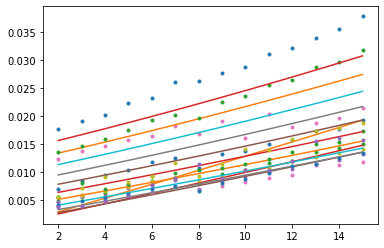

In [1595]:
#plot
for i in num_ranks:
    plt.plot(df_rank_halo_data[str(i)],'.')
    plt.plot(df_rank_halo_model[str(i)])

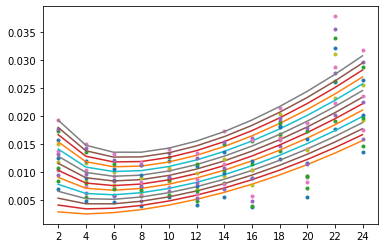

In [1596]:
#plot
for i in num_halos:
    plt.plot(df_rank_halo_data.loc[i],'.')
    plt.plot(df_rank_halo_model.loc[i])

In [1597]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.780
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     194.3
Date:                Sat, 24 Sep 2022   Prob (F-statistic):           9.42e-54
Time:                        22:38:22   Log-Likelihood:                 723.41
No. Observations:                 168   AIC:                            -1439.
Df Residuals:                     164   BIC:                            -1426.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          6.052e-10   5.91e-11     10.246      0.000    4.89e-10    7.22e-10
x2          2.017e-12   3.51e-13      5.748      0.000    1.32e-12    2.71e-12
const       8.136e-06   1.86e-05      0.437      0.663   -2.87e-05    4.49e-05
x3          5.753e-07   6.73e-08      8.547      0.000    4.42e-07    7.08e-07
==============================================================================
Omnibus:                       11.427   Durbin-Watson:                   0.298
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               12.607
Skew:                           0.525   Prob(JB):                      0.00183
Kurtosis:                       3.837   Cond. No.                     1.34e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.34e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

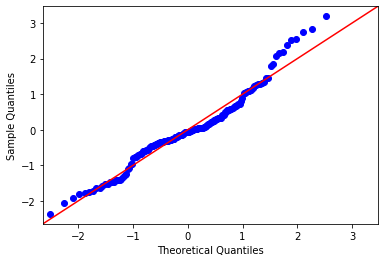

In [1598]:
res=results.resid
fig=sm.qqplot(res,  fit=True, line='45')
plt.show()

In [1599]:
#version with caches
"""
num_iter=10
nx=512
ny=512
nz=32
beta_within_ranks=np.array([1/68.3,1/77.5,1/155,1/155])/1e9
cachesize=[32e3,256e3,30e6,64e9]
lat_cache=np.array([4,11,36,100])/(3e9)
df_runtime_model = pd.DataFrame(index=num_halos)
for p in range(len(num_ranks)):
    for j in range(len(num_halos)):

        if 3*4*(nx+2)*(ny+2)*nz/num_ranks[p]<cachesize[0]:
            df_runtime_model.at[num_halos[j],str(num_ranks[p])]=num_iter*lat_cache[0]*(nx+2)*(ny+2)*nz/num_ranks[p]+ df_rank_halo_model[str(num_ranks[p])][num_halos[j]]
        else:
            for i in range(len(cachesize)):
                if cachesize[i]<3*4*(nx+2)*(ny+2)*nz/num_ranks[p]<cachesize[i+1]:
                    df_runtime_model.at[num_halos[j],str(num_ranks[p])]=0.5*num_iter*lat_cache[i+1]*(nx+2)*(ny+2)*nz/num_ranks[p]#+ beta_within_ranks[i]*nx*ny*nz/p
                    break
             #+ beta_within_ranks[i]*nx*ny*nz/p





"""

'\nnum_iter=10\nnx=512\nny=512\nnz=32\nbeta_within_ranks=np.array([1/68.3,1/77.5,1/155,1/155])/1e9\ncachesize=[32e3,256e3,30e6,64e9]\nlat_cache=np.array([4,11,36,100])/(3e9)\ndf_runtime_model = pd.DataFrame(index=num_halos)\nfor p in range(len(num_ranks)):\n    for j in range(len(num_halos)):\n\n        if 3*4*(nx+2)*(ny+2)*nz/num_ranks[p]<cachesize[0]:\n            df_runtime_model.at[num_halos[j],str(num_ranks[p])]=num_iter*lat_cache[0]*(nx+2)*(ny+2)*nz/num_ranks[p]+ df_rank_halo_model[str(num_ranks[p])][num_halos[j]]\n        else:\n            for i in range(len(cachesize)):\n                if cachesize[i]<3*4*(nx+2)*(ny+2)*nz/num_ranks[p]<cachesize[i+1]:\n                    df_runtime_model.at[num_halos[j],str(num_ranks[p])]=0.5*num_iter*lat_cache[i+1]*(nx+2)*(ny+2)*nz/num_ranks[p]#+ beta_within_ranks[i]*nx*ny*nz/p\n                    break\n             #+ beta_within_ranks[i]*nx*ny*nz/p\n\n\n\n\n\n'

In [1600]:
nx*ny*nz*3*4/2


array([25165823.99999999, 12582912.        ,  8388608.        ,
        6291456.        ,  5033164.8       ,  4194304.        ,
        3595117.71428571,  3145728.        ,  2796202.66666667,
        2516582.4       ,  2287802.18181818,  2097152.        ])

In [1601]:
#Create datframe for linear regression
df_runtime_theory = pd.DataFrame(columns = ['X1','X2','Y'])
num_iter=10
nx=512
ny=512
nz=32

counter=0
for p in range(len(num_ranks)):
    for h in range(len(num_halos)):
        df_runtime_theory.at[counter,'X1']=num_iter*(nx+2)*(ny+2)*nz/num_ranks[p]
        df_runtime_theory.at[counter,'X2']=num_iter
        df_runtime_theory.at[counter,'Y']= z_runtime[counter]-z_tot[counter]

        counter+=1

#linear fit


X1= np.asarray(df_runtime_theory['X1'], dtype=float)
X2= np.asarray(df_runtime_theory['X2'], dtype=float)
Y= np.asarray(df_runtime_theory['Y'], dtype=float)

X=np.column_stack((X1,X2))
model=sm.OLS(Y,X)
results=model.fit()

In [1602]:
df_runtime_data = pd.DataFrame(index=num_halos)
df_runtime_model=pd.DataFrame(index=num_halos)
for i in range(len(num_ranks)):
    df_runtime_data[str(num_ranks[i])]=np.array(z_runtime[i*14:(i+1)*14])
    df_runtime_model[str(num_ranks[i])]=results.params[0]*X1[i*14:(i+1)*14]+results.params[1]*X2[i*14:(i+1)*14]+df_rank_halo_model[str(num_ranks[i])]

In [1603]:
results.params

array([2.56950070e-09, 2.21922921e-03])

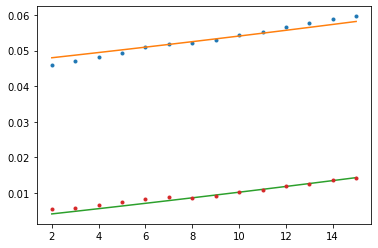

In [1604]:
#plot -> overestimation for few ranks, underestimation for few
#maybe slight increase with number of halopoints has to do with scatter/gather that is not included in halo_update
i=10
plt.plot(df_runtime_data[str(i)],'.')
plt.plot(df_runtime_model[str(i)])
plt.plot(df_rank_halo_model[str(i)])
plt.plot(df_rank_halo_data[str(i)],'.')
#plt.plot(df_runtime_lap_data[str(i)], 'k.')

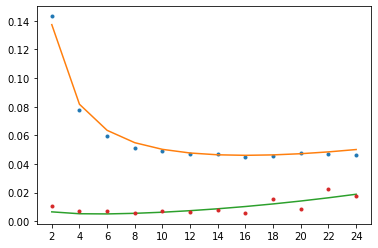

In [1605]:
#plot
i=5
plt.plot(df_runtime_data.loc[i],'.')
plt.plot(df_runtime_model.loc[i])
plt.plot(df_rank_halo_model.loc[i])
plt.plot(df_rank_halo_data.loc[i],'.')
#plt.plot(df_runtime_lap_data.loc[12],'.')

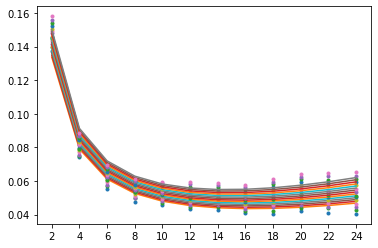

In [1606]:
for i in num_halos:
    plt.plot(df_runtime_data.loc[i],'.')
    plt.plot(df_runtime_model.loc[i])

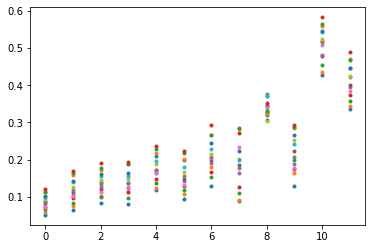

In [1607]:
ratio=[]   

for j in num_halos:
    ratio1=[]     
    for i in num_ranks: 
    

        ratio.append(df2_plot.loc[j-2][str(i)][0][1]/df2_plot.loc[j-2][str(i)][0][0])
        ratio1.append(df2_plot.loc[j-2][str(i)][0][1]/df2_plot.loc[j-2][str(i)][0][0])

    plt.plot(ratio1,'.')

'\ndf_runtime_diff_model = pd.DataFrame(index=num_halos)\na=1\n#b=5/6\n\n#a=results_diff_model.params[0]\n#b=results_diff_model.params[1]\n\nfor p in range(len(num_ranks)):\n    for j in range(len(num_halos)):\n        cachesize=[32e3,256e3,30e6/num_ranks[p],64e9]\n        \n        if 4*(nx+2)*(ny+2)*nz/num_ranks[p]<cachesize[0]:\n            df_runtime_diff_model.at[num_halos[j],str(num_ranks[p])]=num_iter*(nx+2)*(ny+2)*nz/num_ranks[p]*lat_cache[0]\n        else:\n            for i in range(len(cachesize)):\n                if cachesize[i]<4*(nx+2)*(ny+2)*nz/num_ranks[p]<cachesize[i+1]:\n                    df_runtime_diff_model.at[num_halos[j],str(num_ranks[p])]=a*num_iter*(nx+2)*(ny+2)*nz/num_ranks[p]*lat_cache[0]#lat_cache[i+1] + b*num_iter*lat_cache[i]*(nx+2)*(ny+2)*nz/num_ranks[p]\n                    break\n\nplt.plot(df_runtime_diff_model.loc[12])\n'

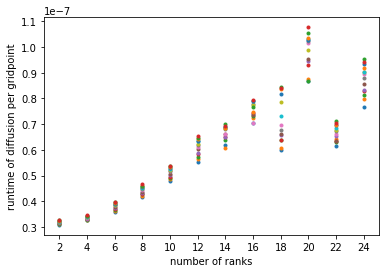

In [1608]:
#attempt where all ranks only access cache L1
nx=512
ny=512
nz=32

diff=df_runtime_data-df_rank_halo_data
#diff=df_runtime_lap_data
diff_new = pd.DataFrame(index=num_halos)
for h in num_halos:
    for p in num_ranks:
        diff_new.at[h,str(p)]=diff[str(p)][h]/((nx+2)*(ny+2)*nz/p)
        
for i in num_halos:
    plt.plot(diff_new.loc[i],'.')
plt.xlabel('number of ranks')
plt.ylabel('runtime of diffusion per gridpoint')

plt.savefig('runtime.pdf')


'''
a=results_diff_model.params[0]
b=results_diff_model.params[1]
#c=results_diff_model.params[1]


df_runtime_diff_model = pd.DataFrame(index=num_halos)
for p in range(len(num_ranks)):
    for j in range(len(num_halos)):

        df_runtime_diff_model.at[num_halos[j],str(num_ranks[p])]=(num_iter*(nx+2)*(ny+2)*nz/num_ranks[p])*lat_cache[2]
plt.plot(df_runtime_diff_model.loc[i])
'''

'''
df_runtime_diff_model = pd.DataFrame(index=num_halos)
a=1
#b=5/6

#a=results_diff_model.params[0]
#b=results_diff_model.params[1]

for p in range(len(num_ranks)):
    for j in range(len(num_halos)):
        cachesize=[32e3,256e3,30e6/num_ranks[p],64e9]
        
        if 4*(nx+2)*(ny+2)*nz/num_ranks[p]<cachesize[0]:
            df_runtime_diff_model.at[num_halos[j],str(num_ranks[p])]=num_iter*(nx+2)*(ny+2)*nz/num_ranks[p]*lat_cache[0]
        else:
            for i in range(len(cachesize)):
                if cachesize[i]<4*(nx+2)*(ny+2)*nz/num_ranks[p]<cachesize[i+1]:
                    df_runtime_diff_model.at[num_halos[j],str(num_ranks[p])]=a*num_iter*(nx+2)*(ny+2)*nz/num_ranks[p]*lat_cache[0]#lat_cache[i+1] + b*num_iter*lat_cache[i]*(nx+2)*(ny+2)*nz/num_ranks[p]
                    break

plt.plot(df_runtime_diff_model.loc[12])
'''

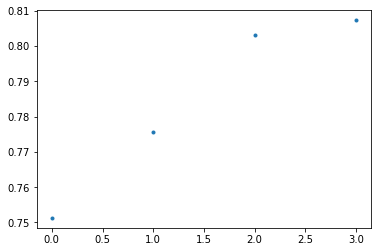

In [1609]:
plt.plot(np.array([0.759-0.774e-2,0.393-0.5249e-2,0.272-0.43e-2,0.2057-0.387e-2])*np.array([1,2,3,4]),'.')

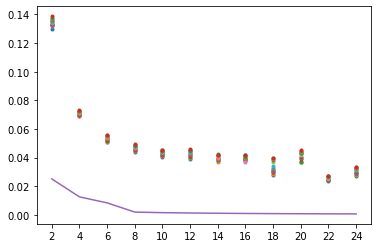

In [1610]:
#attempt where rank where it doesnt fit and largest where it fits are important --> this makes the most sense

diff=df_runtime_data-df_rank_halo_data
for i in num_halos:
    plt.plot(diff.loc[i],'.')

nx=64
ny=64
nz=32

'''
a=results_diff_model.params[0]
b=results_diff_model.params[1]
#c=results_diff_model.params[1]


df_runtime_diff_model = pd.DataFrame(index=num_halos)
for p in range(len(num_ranks)):
    for j in range(len(num_halos)):

        df_runtime_diff_model.at[num_halos[j],str(num_ranks[p])]=(num_iter*(nx+2)*(ny+2)*nz/num_ranks[p])*lat_cache[2]
plt.plot(df_runtime_diff_model.loc[i])
'''
df_runtime_diff_model = pd.DataFrame(index=num_halos)
a=3

#a=results_diff_model.params[0]
#b=results_diff_model.params[1]

for p in range(len(num_ranks)):
    for j in range(len(num_halos)):
        cachesize=[32e3,256e3,30e6/num_ranks[p],64e9]
        #df_runtime_diff_model.at[num_halos[j],str(num_ranks[p])]=num_iter*((nx+2)*(ny+2)*nz/num_ranks[p])*lat_cache[0]*2
        
        if 3*4*(nx+2)*(ny+2)*nz/num_ranks[p]<cachesize[0]:
            df_runtime_diff_model.at[num_halos[j],str(num_ranks[p])]=3*num_iter*(nx+2)*(ny+2)*nz/num_ranks[p]*lat_cache[0]
        else:
            for i in range(len(cachesize)):
                if cachesize[i]<3*4*(nx+2)*(ny+2)*nz/num_ranks[p]<cachesize[i+1]:
                    df_runtime_diff_model.at[num_halos[j],str(num_ranks[p])]=3*num_iter*(nx+2)*(ny+2)*nz/num_ranks[p]*lat_cache[i+1]
                    break
        
plt.plot(df_runtime_diff_model.loc[12])

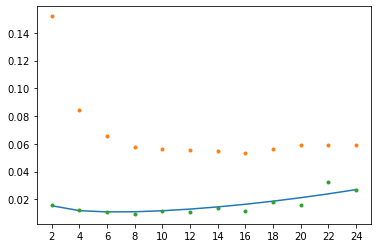

In [1611]:

f_model_tot=df_runtime_diff_model+df_rank_halo_model
df_runtime_data


plt.plot(df_rank_halo_model.loc[12])
plt.plot(df_runtime_data.loc[12],'.')
plt.plot(df_rank_halo_data.loc[12],'.')
#plt.plot(df_model_tot.loc[12][1:])

NameError: name 'df_model_tot' is not defined

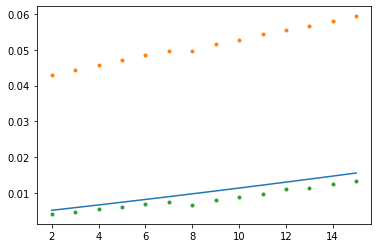

In [1612]:
plt.plot(df_rank_halo_model['12'])
plt.plot(df_runtime_data['12'],'.')
plt.plot(df_rank_halo_data['12'],'.')
plt.plot(df_model_tot['12'])


#discuss fact that for memory part there seems to be slight trend with number of halo-points --> they arent accessed in the code right?

In [ ]:
#Create datframe for linear regression
df_diff_theory = pd.DataFrame(columns = ['X','Y'], index = range(len(num_halos)*(len(num_ranks)-2)))
df_diff_data = pd.DataFrame(columns = ['Z'], index = range(len(num_halos)*(len(num_ranks)-2)))
num_iter=500
nx=64
ny=64
nz=32

counter=0
for p in range(len(num_ranks)):
    for h in range(len(num_halos)):
        cachesize=[32e3,256e3,30e6/num_ranks[p],64e9]  

        for i in range(len(cachesize)):
                if cachesize[i]<4*(nx+2)*(ny+2)*nz/num_ranks[p]<cachesize[i+1]:
                    df_diff_theory.at[counter,'X']=num_iter*lat_cache[i+1]*(nx+2)*(ny+2)*nz/num_ranks[p]
                    df_diff_theory.at[counter,'Y']= (num_iter*(nx+2)*(ny+2)*nz/num_ranks[p])*lat_cache[i]
                    df_diff_data.at[counter,'Z']=diff[str(num_ranks[p])][num_halos[h]]
                    counter+=1
                    break

#linear fit
X= np.asarray(df_diff_theory['X'], dtype=float)
#X=np.asarray(sm.add_constant(X), dtype=float)
Y= np.asarray(df_diff_theory['Y'], dtype=float)
X=np.column_stack((X,Y))
Z=np.asarray(df_diff_data['Z'], dtype=float)
diff_model=sm.OLS(Z,X)
results_diff_model= diff_model.fit()

In [ ]:
results_diff_model.params

array([-2.55100666,  8.90328794])

In [ ]:
diff=df_runtime_data-df_rank_halo_data
for i in num_halos:
    plt.plot(diff.loc[i],'.')

nx=64
ny=64
nz=32

'''
a=results_diff_model.params[0]
b=results_diff_model.params[1]
#c=results_diff_model.params[1]


df_runtime_diff_model = pd.DataFrame(index=num_halos)
for p in range(len(num_ranks)):
    for j in range(len(num_halos)):

        df_runtime_diff_model.at[num_halos[j],str(num_ranks[p])]=(num_iter*(nx+2)*(ny+2)*nz/num_ranks[p])*lat_cache[2]
plt.plot(df_runtime_diff_model.loc[i])
'''
df_runtime_diff_model = pd.DataFrame(index=num_halos)
a=0.2
b=0.8

for p in range(len(num_ranks)):
    for j in range(len(num_halos)):
        cachesize=[32e3,256e3,30e6/num_ranks[p],64e9]
        
        if 4*(nx+2)*(ny+2)*nz/num_ranks[p]<cachesize[0]:
            df_runtime_diff_model.at[num_halos[j],str(num_ranks[p])]=num_iter*lat_cache[0]*(nx+2)*(ny+2)*nz/num_ranks[p]
        else:
            for i in range(len(cachesize)):
                if cachesize[i]<4*(nx+2)*(ny+2)*nz/num_ranks[p]<cachesize[i+1]:
                    df_runtime_diff_model.at[num_halos[j],str(num_ranks[p])]=a*num_iter*lat_cache[i+1]*(nx+2)*(ny+2)*nz/num_ranks[p] + b*num_iter*lat_cache[i]*(nx+2)*(ny+2)*nz/num_ranks[p]
                    break

plt.plot(df_runtime_diff_model.loc[12])

In [ ]:

num_iter=500
nx=64
ny=64
nz=32
beta_within_ranks=np.array([1/68.3,1/77.5,1/155,1/155])/1e9
cachesize=[32e3,256e3,30e6,64e9]
lat_cache=np.array([4,11,36,100])/(3e9)
df_runtime_diff_model = pd.DataFrame(index=num_halos)
for p in range(len(num_ranks)):
    for j in range(len(num_halos)):

            df_runtime_diff_model.at[num_halos[j],str(num_ranks[p])]=num_iter*lat_cache[1]*(nx+2)*(ny+2)*nz/num_ranks[p]


In [ ]:

plt.plot(df_runtime_diff_model.loc[i],'.')

KeyError: 0